In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import seaborn as sns
import statsmodels.formula.api as smf
import ratmetab
import itertools
import re
if os.getlogin() == 'jonesa7':
    import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = ratmetab.read_all_data()

def insert_centered_LIscore(dataset, data=data):
    df = data[dataset]
    s = df.LIscore - df.LIscore.mean()
    val = pd.concat([pd.DataFrame({'LIscore cent.': s}, index=df.index), df], axis=1)
    return(val)

def insert_standardized_LIscore(dataset, data=data):
    df = data[dataset]
    s = (df.LIscore - df.LIscore.mean()) / df.LIscore.std()
    val = pd.concat([pd.DataFrame({'LIscore std.': s}, index=df.index), df], axis=1)
    return(val)

def insert_age(dataset, data=data):
    df = data[dataset]
    l = [(lambda g: 'Y' if g == 'Y' else 'A')(group) for group in df.Group]
    val = pd.concat([pd.DataFrame({'Age': l}, index=df.index), df], axis=1)
    return(val)

def standardize_data(dataset, data=data, non_metab_cols=['LIscore std.', 'LIscore cent.', 'Age', 'LIscore', 'Group']):
    df = data[dataset]
    left = df[non_metab_cols]
    right = df.drop(non_metab_cols, axis=1)
    right_std = (right - right.mean()) / right.std()
    val = pd.concat([left, right_std], axis=1)
    return(val)

data = {dataset: insert_age(dataset, data=data) for dataset in data.keys()}
data = {dataset: insert_centered_LIscore(dataset, data=data) for dataset in data.keys()}
data = {dataset: insert_standardized_LIscore(dataset, data=data) for dataset in data.keys()}
data = {dataset: standardize_data(dataset, data=data) for dataset in data.keys()}

In [3]:
fpath = '../../results/2022-11-09-rat-metabolites/summary.csv'
summary = pd.read_csv(fpath, index_col=0)
summary

,Dataset,Comparison,Analyte class,Metabolite,Effect size,"""- log p""",p,Corrected p,Reject H0,Bonferroni alpha,Direction of change,Rank,Subclass
Phosphatidylcholine aa C40:5,blood new,AI vs. AU,Phosphatidylcholines,Phosphatidylcholine aa C40:5,-0.656900,1.831301,0.014747,0.769241,False,0.000174,Decrease,1,Phosphatidylcholines
Linolenic acid,blood new,AI vs. AU,Free_Fatty_Acids,Linolenic acid,-0.442021,1.707973,0.019590,0.769241,False,0.000174,Decrease,2,Free_Fatty_Acids
"5-beta,6-beta-Epoxycholesterol",blood new,AI vs. AU,Free_Oxysterols,"5-beta,6-beta-Epoxycholesterol",-1.162864,1.677275,0.021024,0.769241,False,0.000174,Decrease,3,Free_Oxysterols_Non_Enzymatic
Spermine,blood new,AI vs. AU,Amino_Acids_and_Biogenic_Amines,Spermine,0.550324,1.646695,0.022558,0.769241,False,0.000174,Increase,4,Amino_Acids_and_Biogenic_Amines
trans-4-Hydroxyproline,blood new,AI vs. AU,Amino_Acids_and_Biogenic_Amines,trans-4-Hydroxyproline,0.969954,1.588279,0.025806,0.769241,False,0.000174,Increase,5,Amino_Acids_and_Biogenic_Amines
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Phosphatidylcholine ae C36:4,brain,AU vs. Y,Phosphatidylcholines,Phosphatidylcholine ae C36:4,0.007427,0.010128,0.976949,0.988861,False,0.000198,Increase,248,Phosphatidylcholines
Docosapentaenoic acid (DPA),brain,AU vs. Y,Free_Fatty_Acids,Docosapentaenoic acid (DPA),-0.012469,0.009134,0.979188,0.988861,False,0.000198,Decrease,249,Free_Fatty_Acids
Leucine,brain,AU vs. Y,Amino_Acids_and_Biogenic_Amines,Leucine,-0.002016,0.008325,0.981013,0.988861,False,0.000198,Decrease,250,Amino_Acids_and_Biogenic_Amines
Sphingomyelin C18:0,brain,AU vs. Y,Sphingomyelins,Sphingomyelin C18:0,-0.001245,0.001622,0.996273,0.997424,False,0.000198,Decrease,251,Sphingomyelins


Top 10 metabolites for the AI vs. AU comparison in the blood data set

In [4]:
top10 = summary.loc[(summary.Dataset == 'blood') & (summary.Comparison == 'AI vs. AU') & (summary.Rank <= 16), 'Metabolite'].to_list()
top10

['Phosphatidylcholine aa C40:5',
 'Phosphatidylcholine aa C40:4',
 '24,25-Epoxycholesterol',
 '24,25-Dihydrolanosterol',
 'Desmosterol',
 '5-beta,6-beta-Epoxycholesterol',
 'Dihydroceramide C22:0',
 'Phosphatidylcholine aa C42:4',
 'Phosphatidylcholine aa C42:5',
 'Phosphatidylcholine ae C42:2',
 'Phosphatidylcholine aa C40:2',
 'Hydroxysphingomyelin C14:1',
 'Phosphatidylcholine aa C38:3',
 'Spermine',
 'Phosphatidylcholine aa C42:6',
 '7-alpha-Hydroxycholesterol']

Text(0, 0.5, 'LIscore')

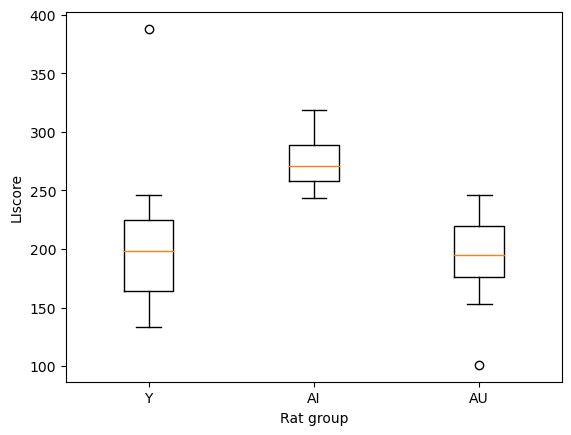

In [5]:
df = data['blood']
d = {group: df.loc[df.Group == group, 'LIscore'] for group in ['Y', 'AI', 'AU']}
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_xlabel('Rat group')
ax.set_ylabel('LIscore')

Text(0, 0.5, 'LIscore')

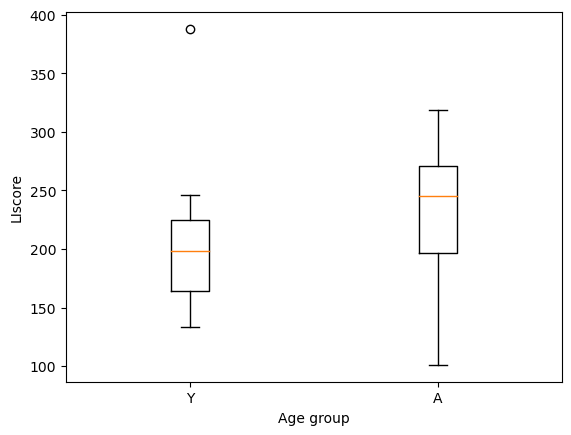

In [6]:
df = data['blood']
d = {group: df.loc[df.Age == group, 'LIscore'] for group in ['Y', 'A']}
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_xlabel('Age group')
ax.set_ylabel('LIscore')

In [7]:
def metab_LI_scatter(metabolite, dataset, data=data):
    df = data[dataset]
    dat = df.loc[df.Group.isin(['AI', 'AU']), ['LIscore', metabolite]]
    fig, ax = plt.subplots()
    sns.regplot(x='LIscore', y=metabolite, data=dat, ax=ax)
    #ax.scatter(x='LIscore', y=metabolite, data=dat)
    ax.set_xlabel('LIscore')
    ax.set_ylabel('metabolite level')
    ax.set_title(metabolite)
    return((fig, ax))

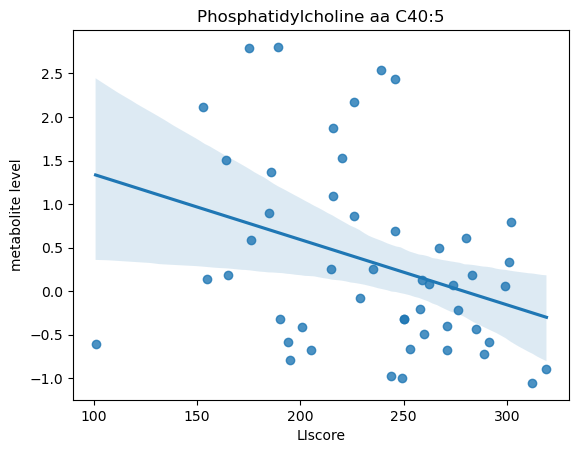

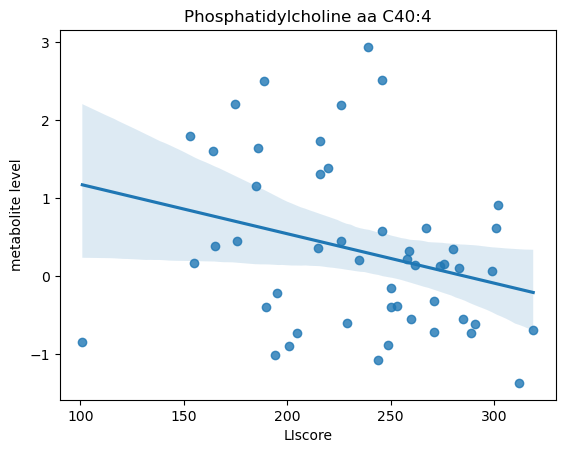

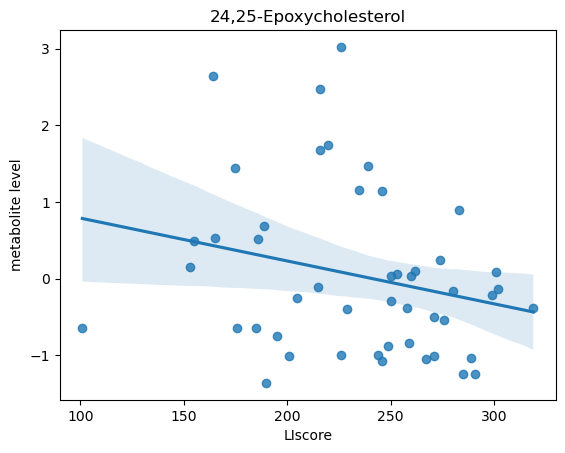

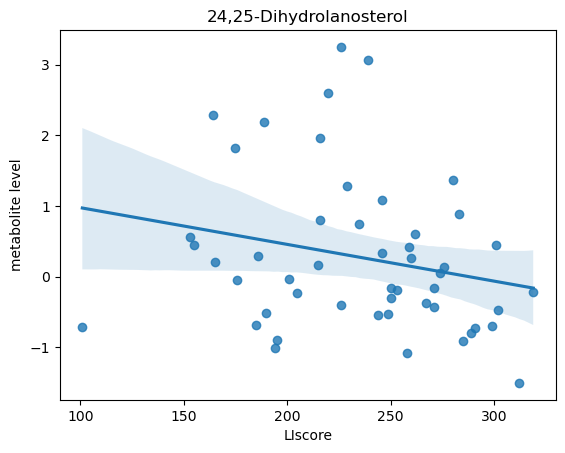

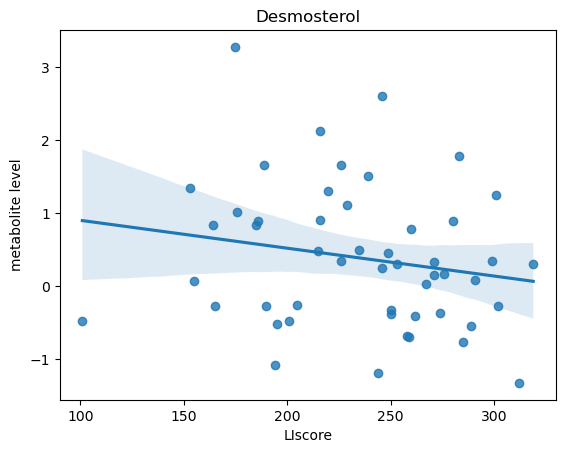

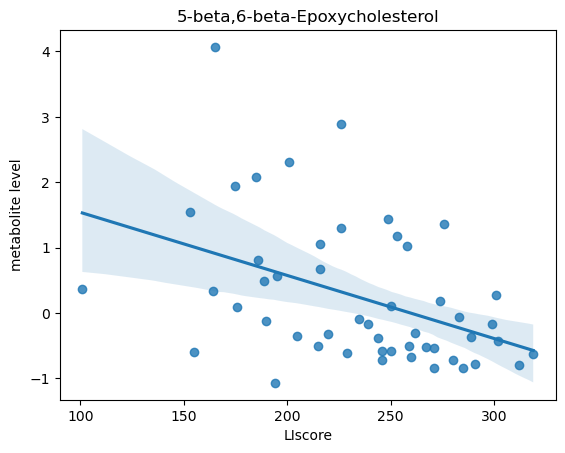

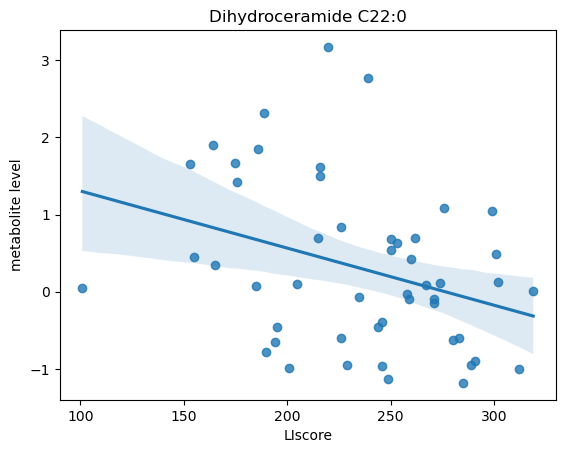

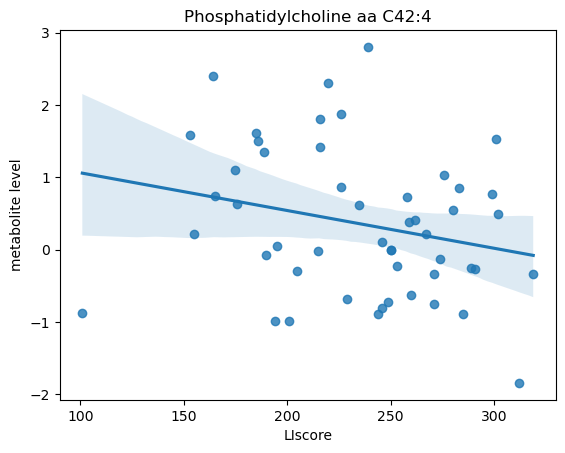

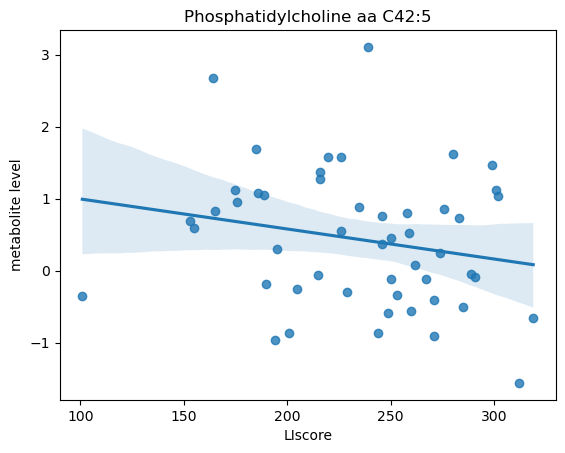

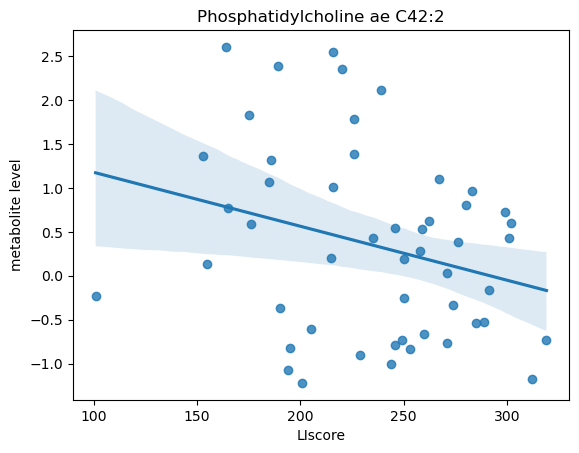

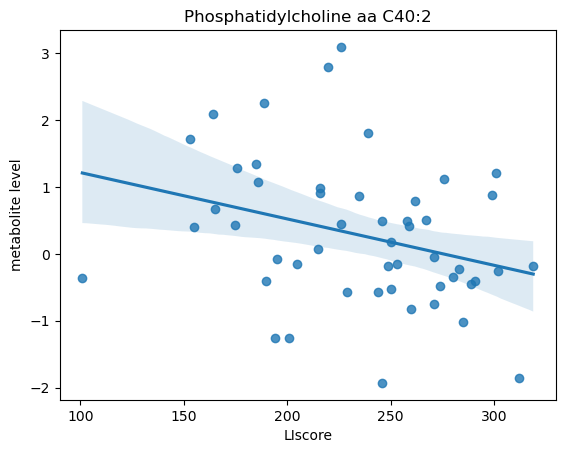

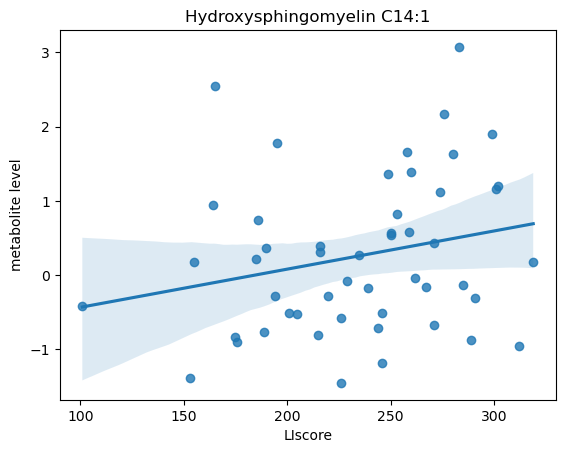

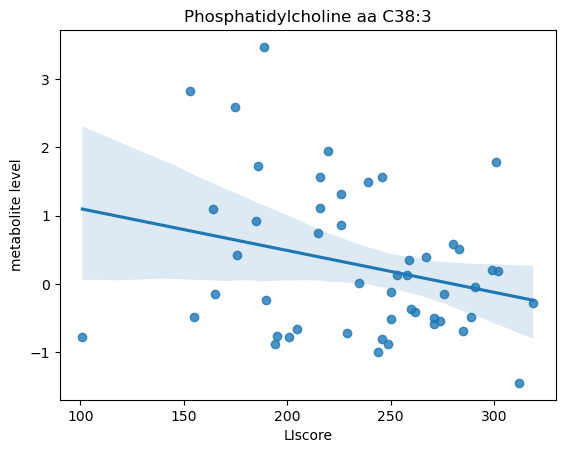

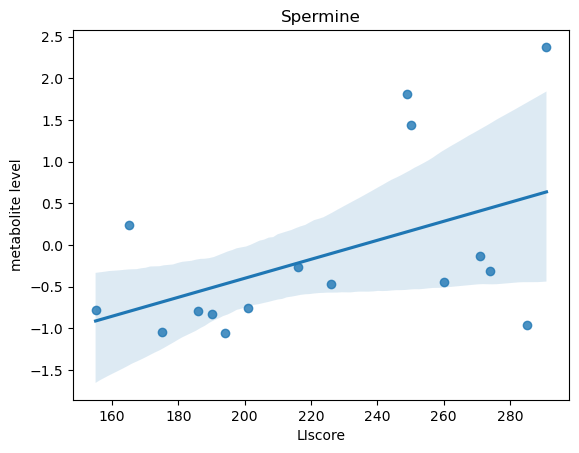

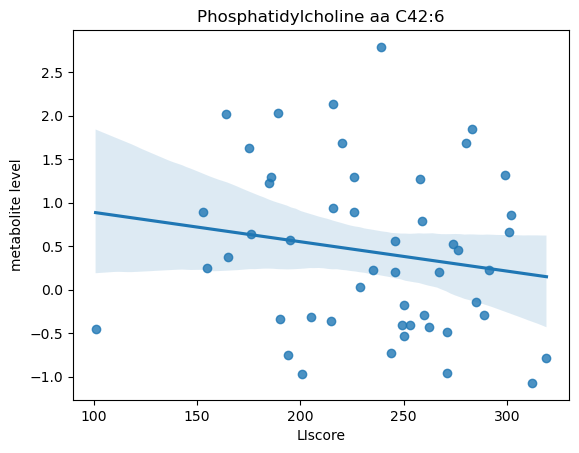

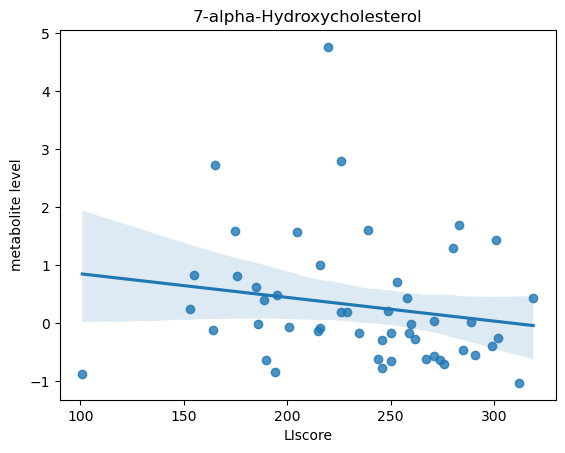

In [8]:
for metabolite in top10:
    fig, ax = metab_LI_scatter(metabolite, 'blood')

total variance = explained variance + unexplained variance

R^2 = (total variance - unexplained variance) / explained variance

## Designing linear models

### Model $M_1$: baseline age: aged, A

Formula `f1 = Q("Phosphatidylcholine aa C40:5") ~ Age + LIscore + Age:LIscore`

Equation:
$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \epsilon_i,
\hspace{2em}
i = 1,...,n=75
$

where
* $y$: Phosphatidylcholine aa C40:5 level
* $\beta_0$: intercept
* $\beta_1 x_{i1}$: effect of age, relative to A (aged)
* $\beta_2 x_{i2}$: interpretation?
* $\beta_3 x_{i1} x_{i2}$: interpretation?

### Model $M_2$: baseline age: young, Y

Formula `f2 = Q("Phosphatidylcholine aa C40:5") ~ C(Age, levels=["Y", "A"]) + LIscore + Age:LIscore`

Equation:
$
y_i = \beta_0' + \beta_1' x_{i1}' + \beta_2' x_{i2} + \beta_3' x_{i1}' x_{i2} + \epsilon_i,
\hspace{2em}
i = 1,...,n=75
$

* $y_i$: Phosphatidylcholine aa C40:5 level
* $\beta_0'$: intercept
* $\beta_1' x_{i1}'$: effect of age, relative to Y (young)
* $\beta_2' x_{i2}$: interpretation?
* $\beta_3' x_{i1}' x_{i2}$: interpretation?

#### Note

1. If rat $i$ is Y (young):
    * $\beta_1 x_{i1} = \beta_1$ and $\beta_3 x_{i1} x_{i2} = \beta_3 x_{i2}$ for $M$
    * $\beta_1' x_{i1}' = 0$ and $\beta_3' x_{i1}' x_{i2} = 0$ for $M'$
1. If rat $i$ is A (aged):
    * $\beta_1 x_{i1} = 0$ and $\beta_3 x_{i1} x_{i2} = 0$ for $M$
    * $\beta_1' x_{i1}' = 1$ and $\beta_3' x_{i1}' x_{i2} = \beta_3' x_{i2}$ for $M'$

## Fitting linear models

In [9]:
dataset = 'blood'
metabolite = 'Phosphatidylcholine aa C40:5'
f1 = 'Q("' + metabolite + '")' + ' ~ Age * LIscore'
f2 = 'Q("' + metabolite + '")' + ' ~ C(Age, levels=["Y", "A"]) * LIscore'
f3 = 'Q("' + metabolite + '")' + ' ~ Age * Q("LIscore std.")'
f4 = 'Q("' + metabolite + '")' + ' ~ Age + Age : Q("LIscore std.")'
f5 = 'Q("' + metabolite + '")' + ' ~ C(Age, levels=["Y", "A"]) * Q("LIscore std.")'
df = data[dataset]
result1, result2, result3, result4, result5 = [smf.ols(f, data=df).fit() for f in [f1, f2, f3, f4, f5]]

### Model $M_1$

* reference age: aged, A

We quantify the effect of young, Y rats with respect to aged, A, rats.

In [10]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 02 Mar 2023   Prob (F-statistic):           8.92e-06
Time:                                       07:43:01   Log-Likelihood:                -92.204
No. Observations:                                 75   AIC:                             192.4
Df Residuals:                                     71   BIC:                             201.7
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0922      0.606      3.455      0.001       0.885       3.300
Age[T.Y]            -2.8456      0.941     -3.023      0.003      -4.723      -0.969
LIscore             -0.0075      0.003     -2.970      0.004      -0.013      -0.002
Age[T.Y]:LIscore     0.0080      0.004      1.860      0.067      -0.001       0.017
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                     2.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model $M_2$

* reference age: young, Y

We quantify the effect of aged, A rats with respect to young, Y, rats.

In [11]:
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 02 Mar 2023   Prob (F-statistic):           8.92e-06
Time:                                       07:43:01   Log-Likelihood:                -92.204
No. Observations:                                 75   AIC:                             192.4
Df Residuals:                                     71   BIC:                             201.7
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -0.7534      0.721     -1.045      0.299      -2.190       0.684
C(Age, levels=["Y", "A"])[T.A]             2.8456      0.941      3.023      0.003       0.969       4.723
LIscore                                    0.0005      0.003      0.135      0.893      -0.006       0.007
C(Age, levels=["Y", "A"])[T.A]:LIscore    -0.0080      0.004     -1.860      0.067      -0.017       0.001
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                     3.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model $M_3$:

* reference age: aged, A
* centered LIscore

In [12]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 02 Mar 2023   Prob (F-statistic):           8.92e-06
Time:                                       07:43:01   Log-Likelihood:                -92.204
No. Observations:                                 75   AIC:                             192.4
Df Residuals:                                     71   BIC:                             201.7
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.4109      0.123      3.331      0.001       0.165       0.657
Age[T.Y]                      -1.0595      0.223     -4.748      0.000      -1.504      -0.615
Q("LIscore std.")             -0.3816      0.128     -2.970      0.004      -0.638      -0.125
Age[T.Y]:Q("LIscore std.")     0.4054      0.218      1.860      0.067      -0.029       0.840
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                         2.88
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model $M_4$:

* no reference age: the effect of LIscore is estimated separately in
    1. young, Y rats
    1. aged, A rats
* centered LIscore

In [13]:
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 02 Mar 2023   Prob (F-statistic):           8.92e-06
Time:                                       07:43:01   Log-Likelihood:                -92.204
No. Observations:                                 75   AIC:                             192.4
Df Residuals:                                     71   BIC:                             201.7
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.4109      0.123      3.331      0.001       0.165       0.657
Age[T.Y]                    -1.0595      0.223     -4.748      0.000      -1.504      -0.615
Age[A]:Q("LIscore std.")    -0.3816      0.128     -2.970      0.004      -0.638      -0.125
Age[Y]:Q("LIscore std.")     0.0238      0.176      0.135      0.893      -0.327       0.375
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                         2.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model $M_5$:

* reference age: young, Y
* centered LIscore

In [14]:
result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Q("Phosphatidylcholine aa C40:5")   R-squared:                       0.306
Model:                                           OLS   Adj. R-squared:                  0.277
Method:                                Least Squares   F-statistic:                     10.45
Date:                               Thu, 02 Mar 2023   Prob (F-statistic):           8.92e-06
Time:                                       07:43:01   Log-Likelihood:                -92.204
No. Observations:                                 75   AIC:                             192.4
Df Residuals:                                     71   BIC:                             201.7
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -0.6486      0.186     -3.488      0.001      -1.019      -0.278
C(Age, levels=["Y", "A"])[T.A]                       1.0595      0.223      4.748      0.000       0.615       1.504
Q("LIscore std.")                                    0.0238      0.176      0.135      0.893      -0.327       0.375
C(Age, levels=["Y", "A"])[T.A]:Q("LIscore std.")    -0.4054      0.218     -1.860      0.067      -0.840       0.029
==============================================================================
Omnibus:                        9.073   Durbin-Watson:                   1.797
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.799
Skew:                           0.713   Prob(JB):                       0.0123
Kurtosis:                       3.884   Cond. No.                         4.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpretation

* $M_1$, see `result1.summary()`
    1. `Intercept`: the expected metabolite level in aged, A rats with LIscore = 0
    1. `Age[T.Y]`: the effect of young, Y, rats rel. to aged, A, rats with LIscore = 0
    1. `LIscore`: the effect of LIscore in aged, A rats
    1. `Age[T.Y]:LIscore`: the **additional** effect of LIscore in young, Y, rats
* $M_2$, see `result2.summary()`
    1. `Intercept`: the expected metabolite level in young, Y rats with LIscore = 0
    1. `C(Age, levels=["Y", "A"])[T.A]`: the effect of aged, A, rats rel. to young, Y, rats
    1. `LIscore`: the effect of LIscore in young, Y rats
    1. `C(Age, levels=["Y", "A"])[T.A]:LIscore`: the **additional** effect of LIscore in aged,
* $M_3$, see `result3.summary()`
    1. `Intercept`: the expected metabolite level in young, Y rats with avg. LIscore $\approx$ 224
    1. `Age[T.Y]`: the effect of young, Y, rats rel. to aged, A, rats with avg. LIscore $\approx$ 224
    1. `LIscore`: the effect of LIscore in aged, A rats
    1. `Age[T.Y]:LIscore`: the **additional** effect of LIscore in young, Y, rats
* $M_4$, see `result4.summary()`
    1. `Intercept`: the expected metabolite level in young, Y rats with avg. LIscore $\approx$ 224
    1. `Age[T.Y]`: the effect of young, Y, rats rel. to aged, A, rats with avg. LIscore $\approx$ 224
    1. `Age[A]:Q("LIscore std.")`: the effect of LIscore in aged, A rats
    1. `Age[Y]:Q("LIscore std.")`: the effect of LIscore  in young, Y, rats
* $M_5$, see `result5.summary()`
    1. `Intercept`: the expected metabolite level in young, Y rats with avg. LIscore $\approx$ 224
    1. `C(Age, levels=["Y", "A"])[T.A]`: the effect of aged, A, rats rel. to young, Y, rats with avg. LIscore $\approx$ 224
    1. `Q("LIscore std.")`: the effect of LIscore in young, Y rats
    1. `C(Age, levels=["Y", "A"])[T.A]:Q("LIscore std.")`: the **additional** effect of LIscore in aged, A, rats

When we want to quantify the differential effect of LIscore in both young, Y and aged, A rats **directly**, then $M_4$ is the suitable model.  In this case we can only give an **indirect** estimate, which has no $p$-value, for how much the effect of LIscore changes in adult, A, rats relative to young, Y, rats.
But if we are primarily interested in how the effect of LIscore changes going Y -> A, then $M_5$ is the most suitable.  Both $M_4, M_5$ (and also $M_3$) use centered LIscore, which makes the interpretation for the effect of Age **realistic** by referring to the average LIscore instead of the unrealistic case of LIscore = 0.


## Fitting all the data

In [15]:
def fit1metabolite(metabolite, dataset, data=data, formula=f4):
    df = data[dataset]
    lhs = 'Q("' + metabolite + '")'
    rhs = re.sub('^.*\\~ ', '', formula)
    f = lhs + ' ~ ' + rhs
    result = smf.ols(f, data=df).fit()
    result.summary()
    d = {'Estimate': result.params, 'SE': result.bse, 'p': result.pvalues}
    ll = [a.to_list() for a in d.values()]
    l = itertools.chain(*ll)
    ix = pd.MultiIndex.from_product([d.keys(), d['Estimate'].index])
    df = pd.DataFrame({metabolite: l}, index=ix).transpose()
    df[('Goodness of fit', 'omnipv')] = result.diagn['omnipv']
    df[('Goodness of fit', 'jbpv')] = result.diagn['jbpv']
    df[('General', 'R-squared')] = result.rsquared
    df[('General', 'Dataset')] = dataset
    return(df)


def fit_all(formula=f4, data=data, ttest_summary=summary):
    summary1 = ttest_summary.loc[ttest_summary.Comparison == 'AI vs. AU', ['Dataset', 'Analyte class', 'Metabolite', 'p']]
    l = summary1.apply(lambda s: fit1metabolite(s.Metabolite, s.Dataset, data=data, formula=formula), axis=1)
    regsummary = pd.concat(l.to_list(), axis=0)
    def add_t_test(dataset='blood'):
        left = regsummary.loc[regsummary[('General', 'Dataset')] == dataset]
        right = summary1.loc[summary1['Dataset'] == dataset, ['p']]
        right.columns = pd.MultiIndex.from_product([['t-test'], ['p']])
        val = pd.concat([left, right], axis=1)
        return(val)
    l = [add_t_test(dataset) for dataset in data.keys()]
    regsummary_t = pd.concat(l, axis=0)
    return(regsummary_t)

In [16]:
%%capture --no-display
summary_M4 = fit_all(formula=f4)
summary_M4.to_csv('../../results/2022-12-13-rat-metabolites/summary-M4.csv')
summary_M4

Estimate                                     \
                                 Intercept  Age[T.Y] Age[A]:Q("LIscore std.")   
Phosphatidylcholine aa C40:5      0.356449 -0.931140                -0.561554   
Linolenic acid                   -0.262331  0.980875                -0.475376   
5-beta,6-beta-Epoxycholesterol    0.329063 -0.819515                -0.638930   
Spermine                         -0.089274  0.129060                 0.650573   
trans-4-Hydroxyproline           -0.068441  0.026552                 0.555183   
...                                    ...       ...                      ...   
Phosphatidylcholine aa C32:1      0.065155 -0.237106                -0.000371   
Phosphatidylethanolamine aa 34:0 -0.098405  0.098630                -0.056154   
Sphingomyelin C18:0              -0.007408 -0.036504                 0.028404   
Phosphatidylcholine ae C40:3      0.146134 -0.480238                 0.010119   
Phosphatidylcholine ae C44:4      0.190374 -0.544190                -0.058707   

                                                                 SE            \
                                 Age[Y]:Q("LIscore std.") Intercept  Age[T.Y]   
Phosphatidylcholine aa C40:5                    -0.070244  0.198236  0.346619   
Linolenic acid                                   0.213848  0.192230  0.336117   
5-beta,6-beta-Epoxycholesterol                  -0.042874  0.197845  0.345937   
Spermine                                        -0.555302  0.215096  0.352427   
trans-4-Hydroxyproline                          -0.080322  0.220399  0.385373   
...                                                   ...       ...       ...   
Phosphatidylcholine aa C32:1                    -0.103922  0.149484  0.267642   
Phosphatidylethanolamine aa 34:0                -0.394775  0.201697  0.363798   
Sphingomyelin C18:0                             -0.106260  0.150071  0.268694   
Phosphatidylcholine ae C40:3                    -0.100704  0.146793  0.262824   
Phosphatidylcholine ae C44:4                    -0.064256  0.199321  0.401102   

                                                           \
                                 Age[A]:Q("LIscore std.")   
Phosphatidylcholine aa C40:5                     0.233083   
Linolenic acid                                   0.226021   
5-beta,6-beta-Epoxycholesterol                   0.232624   
Spermine                                         0.281881   
trans-4-Hydroxyproline                           0.259143   
...                                                   ...   
Phosphatidylcholine aa C32:1                     0.155120   
Phosphatidylethanolamine aa 34:0                 0.238422   
Sphingomyelin C18:0                              0.155730   
Phosphatidylcholine ae C40:3                     0.152328   
Phosphatidylcholine ae C44:4                     0.209112   

                                                                  p            \
                                 Age[Y]:Q("LIscore std.") Intercept  Age[T.Y]   
Phosphatidylcholine aa C40:5                     0.235859  0.083782  0.012420   
Linolenic acid                                   0.228713  0.184051  0.007171   
5-beta,6-beta-Epoxycholesterol                   0.235395  0.108275  0.025549   
Spermine                                         0.231577  0.682130  0.717711   
trans-4-Hydroxyproline                           0.262229  0.758632  0.945597   
...                                                   ...       ...       ...   
Phosphatidylcholine aa C32:1                     0.210141  0.664276  0.378700   
Phosphatidylethanolamine aa 34:0                 0.395898  0.628109  0.787602   
Sphingomyelin C18:0                              0.210967  0.960768  0.892323   
Phosphatidylcholine ae C40:3                     0.206359  0.322917  0.071930   
Phosphatidylcholine ae C44:4                     0.427914  0.345559  0.182871   

                                                           \
                 

In [17]:
%%capture --no-display
summary_M5 = fit_all(formula=f5)
summary_M5.to_csv('../../results/2022-12-13-rat-metabolites/summary-M5.csv')
param = 'C(Age, levels=["Y", "A"])[T.A]:Q("LIscore std.")'
summary_M5.sort_values(('p', param))

Estimate                                 \
                                    Intercept C(Age, levels=["Y", "A"])[T.A]   
Spermine                             0.068759                      -0.191978   
Spermine                             0.039786                      -0.129060   
5-alpha,6-alpha-Epoxycholesterol     0.031096                       0.269889   
Ursodeoxycholic acid                 0.333291                      -0.356627   
Lithocholic acid                     0.686536                      -0.900715   
...                                       ...                            ...   
Lysophosphatidylethanolamine a 18:0 -0.653935                       0.980726   
Phosphatidylserine aa 40:6           0.191513                      -0.291147   
Phosphatidylethanolamine ae 40:2     0.408323                      -0.566024   
Phosphatidylcholine ae C42:4        -1.089274                       1.224371   
Phosphatidylcholine ae C42:4        -1.082193                       1.224378   

                                                       \
                                    Q("LIscore std.")   
Spermine                                    -0.494675   
Spermine                                    -0.555302   
5-alpha,6-alpha-Epoxycholesterol             0.782937   
Ursodeoxycholic acid                         0.765278   
Lithocholic acid                             0.697108   
...                                               ...   
Lysophosphatidylethanolamine a 18:0         -0.172523   
Phosphatidylserine aa 40:6                  -0.086871   
Phosphatidylethanolamine ae 40:2            -0.065795   
Phosphatidylcholine ae C42:4                -0.181346   
Phosphatidylcholine ae C42:4                -0.166934   

                                                                                      \
                                    C(Age, levels=["Y", "A"])[T.A]:Q("LIscore std.")   
Spermine                                                                    1.074220   
Spermine                                                                    1.205874   
5-alpha,6-alpha-Epoxycholesterol                                           -1.161225   
Ursodeoxycholic acid                                                       -1.018882   
Lithocholic acid                                                           -0.917781   
...                                                                              ...   
Lysophosphatidylethanolamine a 18:0                                         0.001259   
Phosphatidylserine aa 40:6                                                  0.000249   
Phosphatidylethanolamine ae 40:2                                           -0.000633   
Phosphatidylcholine ae C42:4                                               -0.000169   
Phosphatidylcholine ae C42:4                                               -0.000155   

                                           SE                                 \
                                    Intercept C(Age, levels=["Y", "A"])[T.A]   
Spermine                             0.276605                       0.350099   
Spermine                             0.279175                       0.352427   
5-alpha,6-alpha-Epoxycholesterol     0.296177                       0.340117   
Ursodeoxycholic acid                 0.284068                       0.346291   
Lithocholic acid                     0.270804                       0.330123   
...                                       ...                            ...   
Lysophosphatidylethanolamine a 18:0  0.303737                       0.370269   
Phosphatidylserine aa 40:6           0.224883                       0.276475   
Phosphatidylethanolamine ae 40:2     0.599099                       0.665608   
Phosphatidylcholine ae C42:4         2.267123                       2.277417   
Phosphatidylcholine ae C42:4         2.045105                       2.056863   

                                                       \
           

['named-figure/volcano-M5-age-LIscore-interaction.png',
 'named-figure/volcano-M5-age-LIscore-interaction.pdf']

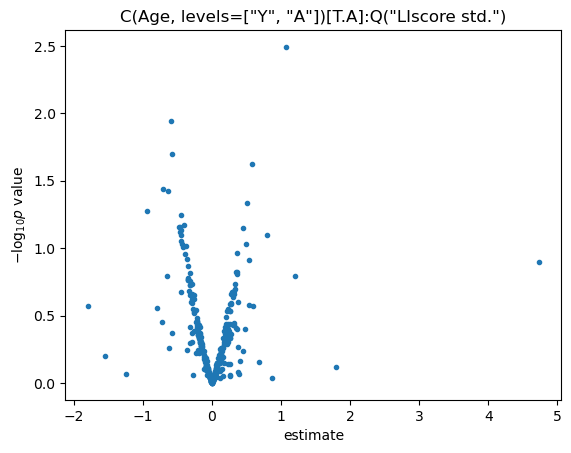

In [18]:
fig, ax = plt.subplots()
def my_volcano(ax, summary=summary_M5, param='C(Age, levels=["Y", "A"])[T.A]:Q("LIscore std.")', dataset='blood'):
    df = summary.loc[summary[('General', 'Dataset')] == dataset]
    x, y = [df[(s, param)] for s in ['Estimate', 'p']]
    ax.scatter(x=x, y=- np.log10(y), marker='.')
    ax.set_title(param)
    ax.set_xlabel('estimate')
    ax.set_ylabel(r'$- \log_{10} p$ value')
    return(ax)

ax = my_volcano(ax)
attila_utils.savefig(fig, 'volcano-M5-age-LIscore-interaction')

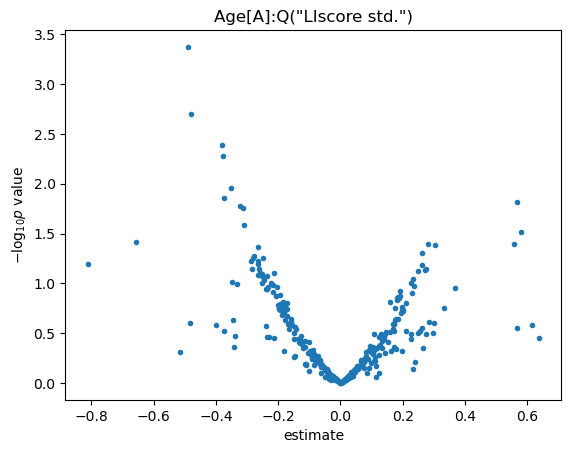

In [19]:
fig, ax = plt.subplots()
ax = my_volcano(ax, summary=summary_M4, param='Age[A]:Q("LIscore std.")')

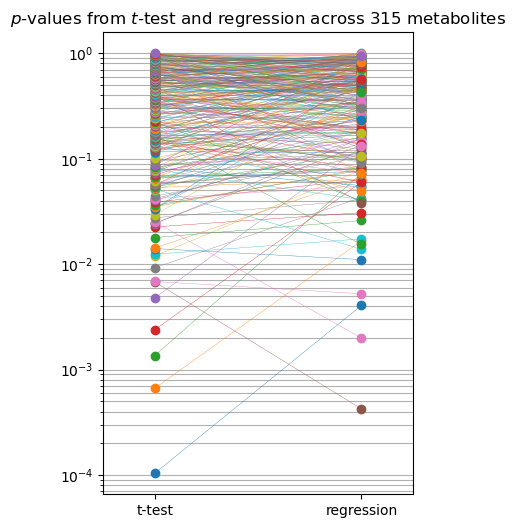

In [20]:
df = summary_M4.loc[summary_M4[('General', 'Dataset')] == 'blood']#.head(10)
fig, ax = plt.subplots(figsize=(4, 6))
for metabolite in df.index:
    p_reg = df.loc[metabolite, ('p', 'Age[A]:Q("LIscore std.")')]
    p_tt = df.loc[metabolite, ('t-test', 'p')]
    ax.plot([-1, 1], [p_tt, p_reg], label=metabolite, marker='o', linewidth=0.25)

ax.set_yscale('log')
ax.set_xlim(-01.5, 1.5)
ax.set_xticks([-1, 1])
ax.set_xticklabels(['t-test', 'regression'])
ax.grid(axis='y', which='both')
ax.set_title(r'$p$-values from $t$-test and regression across ' + str(df.shape[0]) + ' metabolites')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'compare-t_test-regression-pval-blood')

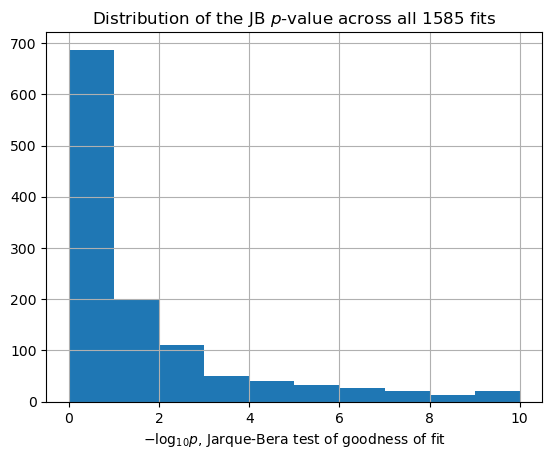

In [21]:
fig, ax = plt.subplots()
summary_M4[('Goodness of fit', 'jbpv')].apply(lambda x: - np.log10(x)).hist(ax=ax, range=(0, 10))
ax.set_xlabel(r'$- \log_{10} p$, Jarque-Bera test of goodness of fit')
ax.set_title(r'Distribution of the JB $p$-value across all ' + str(summary_M4.shape[0]) + ' fits')
if os.getlogin() == 'jonesa7':
    attila_utils.savefig(fig, 'goodness-of-fit-jb-pval-hist')

## TODOs

1. repeat analysis by fitting $M_5$ to get a direct estimation of how the effect of LIscore changes Y -> A (in aged, A, rats relative to young, Y, rats)
1. inspect goodness of fit for the top metabolites
1. design and fit a mixed effec model to each analyte class jointly analyzing all metabolites within that class
    * estimate the average effect of LIscore across all metabolites in the analyte class
    * estimate the variation of the effect across metabolites

In [22]:
%connect_info

{
  "shell_port": 56806,
  "iopub_port": 56807,
  "stdin_port": 56808,
  "control_port": 56810,
  "hb_port": 56809,
  "ip": "127.0.0.1",
  "key": "f3ac079f-5cb9a84496cc464bae7e4ec1",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-6da1ce9d-0af1-4843-9bfd-332742c9cf7b.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
